### (optional) import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install libraries 

In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [ ]:
!pip install matplotlib numpy mesh-to-sdf trimesh plyfile open3d

# Clone the repository to get the data

 To train a DeepSDF model, it is necessary to have a dataset consisting of a collection of 3D shapes. In this notebook, we will use any objects from internet. 

 When we clone the repository, we can find a folder called `dataset`. This folder contains a collection of objects that we will use to train our model.


In [ ]:
!git clone https://github.com/arielz001/Hands-On-DeepSDF.git
%cd Hands-On-DeepSDF

On colab you must deactivate the display

In [ ]:
# import os
# os.environ["PYOPENGL_PLATFORM"] = "egl"
# os.environ["DISPLAY"] = ""

# Understanding SDF values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def example_sdf():
    def circle_sdf(x, y, center, radius):
        return np.sqrt((x - center[0])**2 + (y - center[1])**2) - radius

    x = np.linspace(-150, 150, 400)
    y = np.linspace(-150, 150, 400)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    ax.set_title("Visualization SDF")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal')

    center = [0, 0]
    radius = 80
    Z = circle_sdf(X, Y, center, radius)
    im = ax.imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()],
                cmap='RdBu', origin='lower', vmin=-radius, vmax=radius)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Signed Distance Function')

    contour = ax.contour(X, Y, Z, levels=[0], colors='black', linewidths=2)

    plt.show()
    
example_sdf()

# Dataset

## Preprocessing data

##### Now we must create the sdf values for each obj in the dataset

In [ ]:
from mesh_to_sdf import sample_sdf_near_surface

import os
import glob
import trimesh
import numpy as np


# TODO: Set the number of samples
num_samples = 15000


def generate_xyz_sdf(filename):
    mesh = trimesh.load(os.path.abspath(filename),force='mesh')
    xyz, sdf = sample_sdf_near_surface(mesh, number_of_points=num_samples)
    return xyz, sdf

def writeSDFToNPZ(xyz, sdfs, filename):
    num_vert = len(xyz)
    pos = []
    neg = []

    for i in range(num_vert):   # for each vertex in the shape
        v = xyz[i]   # Point Position Value
        s = sdfs[i]  # Signed Distance Function Value

        if s > 0:
            for j in range(3):
                pos.append(v[j])     # remember that vertex have 3 coordinates
            pos.append(s)            # adding the positive value

        else:
            for j in range(3):
                neg.append(v[j])     # for each coordinate in the vertex
            neg.append(s)            # adding the negative value


    #========================================================================
    # TODO:

    # Save the values reshaping both 'pos' and 'neg' into arrays with 4 columns.
    # The file will contain two named arrays: 'pos' and 'neg', each of shape (N, 4)
    # Where N is the number of vertices in the shape.
    # so you have to reshape the arrays following this order: array.reshape(-1, 4)
    # ========================================================================
    np.savez(filename, pos=None, neg=None)
    
    # ========================================================================


def process(mesh_filepath, target_filepath):
    xyz, sdfs = generate_xyz_sdf(mesh_filepath)
    writeSDFToNPZ(xyz, sdfs, target_filepath)
    


target_path = f"./processed_data"

os.makedirs(target_path, exist_ok=True)

mesh_filenames = list(glob.iglob("dataset/"  + "*.obj"))

N = len(mesh_filenames)
it = 0

for mesh_filepath in mesh_filenames:

    base_name = os.path.splitext(os.path.basename(mesh_filepath))[0]
    target_filepath = os.path.join(target_path, base_name)
    
    print(f"base_name: {base_name}")
    process(mesh_filepath, target_filepath)

    it += 1
    print(f"Process finished directory: {it}/{N}")

#### Shapenet type of dataset

This class implements a custom PyTorch dataset that loads data from `.npz` files and generates balanced samples of positive and negative points.

## How it works

- Reads all `.npz` files from a given folder.
- Each file contains two arrays: positive points (`pos`) and negative points (`neg`).
- For each file, it takes a total of `you can define the quantity of points` points from each array.
- If there are fewer than `num of points that you defined / 2`  of a type, it performs random sampling with replacement to complete the quota.
- If there are more than `num of points that you defined / 2`  points, it takes a random continuous block of that size.
- Concatenates both subsets to form the final sample.
- Stores all loaded samples in an internal list.

## Methods

- `__getitem__(index)`: returns a tuple `(index, sample)` for the sample at the given index.
- `__len__()`: returns the total number of samples (loaded `.npz` files).

---

This dataset is designed to facilitate training models that require balanced samples of positive and negative points from data stored in `.npz` files.


In [ ]:
import torch
from torch.utils.data import Dataset

import numpy as np
import random
from pathlib import Path

class ShapeNet_Dataset(Dataset):
    
    def __init__(self, dataset_path):
        self.dataset = []
        for file_name in sorted(Path(dataset_path).glob("*.npz")):
            

            # TODO: create tensors with torch from numpy
                # remember that npz have 2 arrays: pos and neg
                # and the command is torch.from_numpy(array) 
                # and the numpy arrays are pos_tensor = npz['pos'] and neg_tensor = npz['neg']

            npz = np.load(file_name)
            pos_tensor = None
            neg_tensor = None



            # split the sample into half
            half = int(num_samples / 2)

            pos_size = pos_tensor.shape[0]
            neg_size = neg_tensor.shape[0]
            
            # if size of values is less than half
            # then select random values from the values

            # if size of values is greater than half
            # then select the half from the values

            if pos_size <= half:
                random_pos = (torch.rand(half) * pos_tensor.shape[0]).long()
                sample_pos = torch.index_select(pos_tensor, 0, random_pos)
            else:
                pos_start_ind = random.randint(0, pos_size - half)
                sample_pos = pos_tensor[pos_start_ind : (pos_start_ind + half)]

            if neg_size <= half:
                random_neg = (torch.rand(half) * neg_tensor.shape[0]).long()
                sample_neg = torch.index_select(neg_tensor, 0, random_neg)
            else:
                neg_start_ind = random.randint(0, neg_size - half)
                sample_neg = neg_tensor[neg_start_ind : (neg_start_ind + half)]

            samples = torch.cat([sample_pos, sample_neg], 0)
            
            self.dataset.append(samples)
            
    def __getitem__(self, index):
        return index, self.dataset[index]
    
    def __len__(self):
        return len(self.dataset)

# Define the model

The following image shows the architecture of the DeepSDF model.

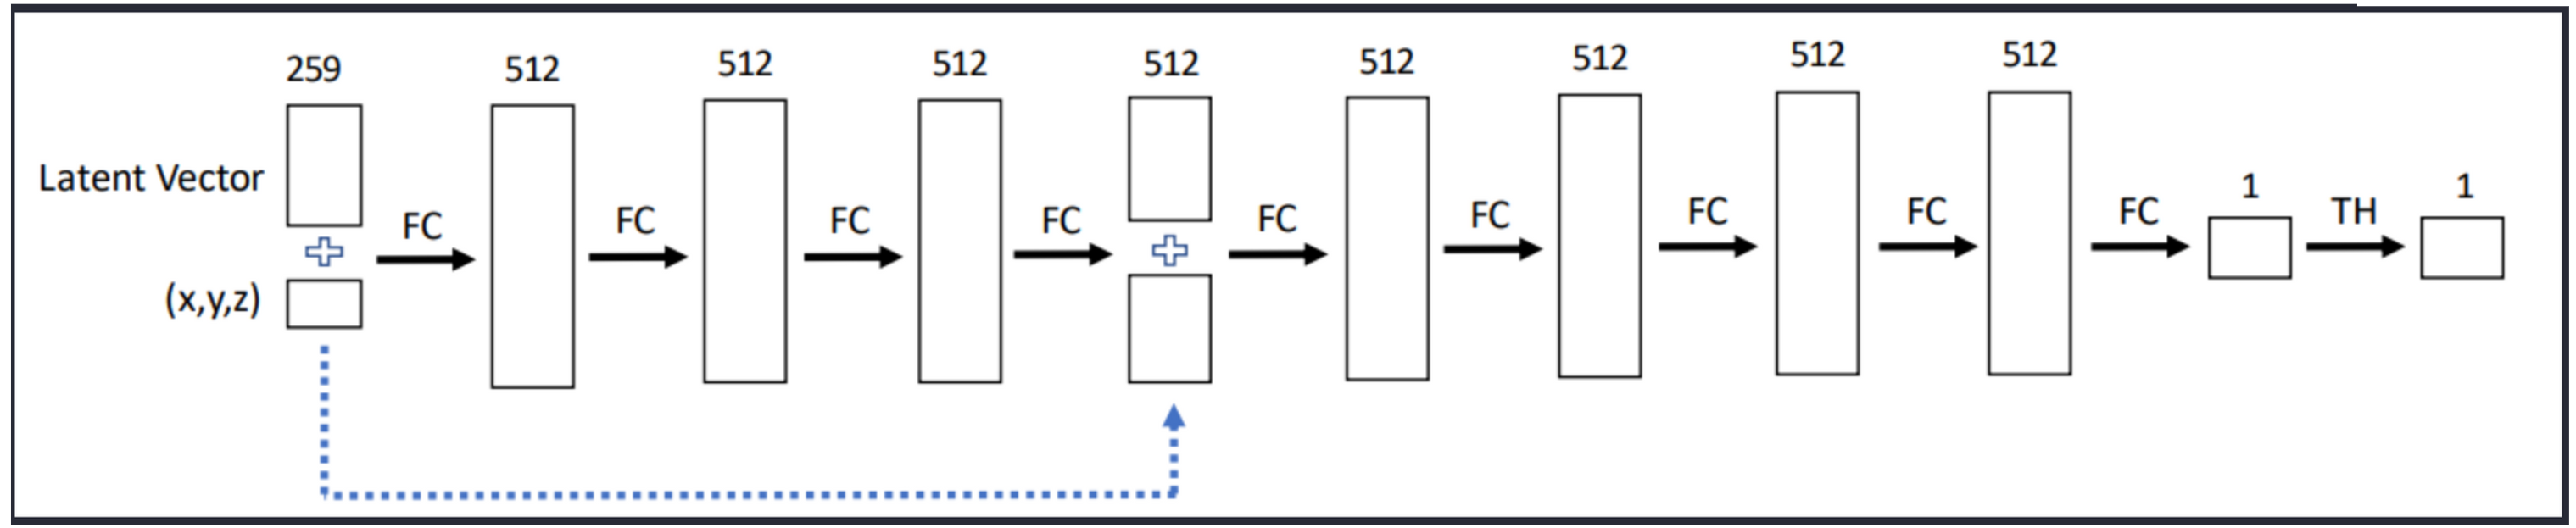

In [1]:
from IPython.display import Image, display
display(Image('./assets/network-arch.png'))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    
    # TODO: we have to define the sizes of the ouput layers following the last image
    #       and in which layer is the latent vector again (in the middle?)
    #       remember change the None values in the init function
    
    def __init__(
        self,
        latent_size=None,
        dims=[None, None, None, None, None, None, None, None, None],  # not consider the first input because is added later
        dropout=[0, 1, 2, 3, 4, 5, 6,7],
        dropout_prob=0.2,
        norm_layers=[0, 1, 2, 3, 4, 5, 6,7],
        latent_in=[None],
        weight_norm=True):

        super(Decoder, self).__init__()
        
        # TODO: change None value adding the size of first input (note: None value is the first layer)
        dims = [None]  + dims

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

        self.relu = nn.ReLU()
        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    def forward(self, input):
        x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
           
            x = lin(x)
            
            if layer < self.num_layers - 2:
                x = self.relu(x)
                if self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return x

# Train the model

The following image shows the loss function

 $\mathcal{L}(f_\theta(z_i, x_j), s_j) = \left| \operatorname{clamp}_\delta(f_\theta(z_i, x_j)) - \operatorname{clamp}_\delta(s_j) \right|$

Set the clamp value

$\operatorname{clamp}(X, \delta) := min(\delta, max(-\delta,x))$

- in the original paper they use $\delta = 0.1$

In [ ]:
import torch
from torch.utils.data import DataLoader

import numpy as np
import random
import os

def train_decoder(epochs = 1000,
                batch_size=5,
                lat_vecs_std = 0.01,
                decoder_lr = 0.0005,
                lat_vecs_lr = 0.001,
                train_data_path = "./processed_data",
                checkpoint_save_path = "./checkpoints/"):
    
    os.makedirs(checkpoint_save_path, exist_ok=True)
    # ------------ set random seed ------------

    np.random.seed(42)
    torch.manual_seed(42)
    random.seed(42)

    # ------------ setting device on GPU if available, else CPU ------------

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

    # ------------ load dataset ------------set parameters

    train_dataset = ShapeNet_Dataset(train_data_path) # sdf values and vertex coordinates (npz file)
    torch_train = DataLoader(train_dataset,shuffle=True, batch_size=batch_size, num_workers=1)

    # ------------ load auto decoder model ------------
    
    SDF_autodecoder = Decoder().to(device)

    # ------------ set training parameters ------------

    # initializa latent vectors
    lat_vecs = torch.nn.Embedding(len(train_dataset), 256, max_norm=1.0).cuda()
    torch.nn.init.normal_(lat_vecs.weight.data, 0.0, lat_vecs_std)

    # set optimizer
    optimizer_all = torch.optim.Adam(
                    [{"params": SDF_autodecoder.parameters(),
                    "lr": decoder_lr},
                    {"params": lat_vecs.parameters(),
                    "lr": lat_vecs_lr}])
    
    # loss function
    loss_l1 = torch.nn.L1Loss(reduction="sum")

    # other parameters

    # ===================================
    # TODO: Set the delta value
    delta = None
    delta_min, delta_max = -delta, delta # clamp
    # ==========================================



    # ------------ training process ------------ 

    print("---- start training ----")
    loss_log = []

    for epoch in range(epochs):
        
        SDF_autodecoder.train()

        losses = []
        
        for index, train_data in torch_train:
            
            train_data = train_data.reshape(-1,4).cuda()
            num_sdf_samples = train_data.shape[0]
            train_data.requires_grad = False

            xyz = train_data[:, 0:3]
            sdf_gt = train_data[:, 3].unsqueeze(1)

            # ========================================================================
            # TODO: Calculate the loss Function
            # torch.clamp() receive 3 parameters, the value, min threshold and max threshold
            sdf_gt = torch.clamp(sdf_gt, None, None)
            # ========================================================================


            optimizer_all.zero_grad()

            # concatenate latent vector and xyz query
            indices = index.cuda().unsqueeze(-1).repeat(1, num_samples).view(-1)
            batch_vecs = lat_vecs(indices)
            input = torch.cat([batch_vecs, xyz], dim=1)

            # NN optimization
            pred_sdf = SDF_autodecoder(input)


            # ========================================================================
            # TODO: Calculate the loss Function
            # torch.clamp() receive 3 parameters, the value, min threshold and max threshold

            pred_sdf = torch.clamp(pred_sdf, None, None)
            real_sdf = sdf_gt.cuda()
            loss_function = loss_l1(None, None)
            loss = loss_function / num_sdf_samples

            # ========================================================================

            loss.backward()
            losses.append(loss.data.mean().cpu())

            optimizer_all.step()
            
        # Print batch loss
        epoch_loss = np.mean(losses)
        loss_log.append(epoch_loss)
        print(f'epoch: {epoch+1} / {epoch} | Loss: {epoch_loss:.5f}')
        
        torch.save({
                'epoch': epoch,
                'model': SDF_autodecoder.state_dict(),
                'latent_vectors': lat_vecs.state_dict(),
                'optimizer': optimizer_all.state_dict(),
                'loss_log': loss_log,
                # }, checkpoint_save_path + str(epoch+1) + ".pt")
                }, checkpoint_save_path  + "trained_model_1.pt")

### TODO: SET PARAMETERS

In [ ]:
# TODO: SET PARAMETERS
train_decoder(epochs = None,
                    batch_size=None,
                    lat_vecs_std = 0.01,
                    decoder_lr = None,
                    lat_vecs_lr = None)

# Reconstruct mesh from a latent code

In [ ]:
import torch

import numpy as np
import plyfile
import skimage.measure

# Learn the latent code for the test model
def reconstruct_latent(decoder, 
                       sdf_data, 
                       iterations = 800,
                       init_std = 0.01, 
                       lr = 5e-4):

    # parameters
    latent_size = 256
    num_samples = num_samples  # this is the same as the number of points in the shapenet dataset class definition 

    # RANDOM LATENT VECTOR

    latent = torch.rand(1, latent_size).normal_(mean=0, std=init_std).cuda()
    latent.requires_grad = True

    # set optimizer and loss
    optimizer = torch.optim.Adam([latent], lr=lr)
    loss_l1 = torch.nn.L1Loss()
    delta_min, delta_max = -0.1, 0.1 # clamp

    for it in range(iterations):
        
        decoder.eval()

        xyz = sdf_data.cuda()[:, 0:3]
        sdf_gt = sdf_data.cuda()[:, 3].unsqueeze(1)
        sdf_gt = torch.clamp(sdf_gt, delta_min, delta_max)

        optimizer.zero_grad()

        latent_inputs = latent.expand(num_samples, -1)
        inputs = torch.cat([latent_inputs, xyz], 1)
        pred_sdf = decoder(inputs)
        pred_sdf = torch.clamp(pred_sdf, delta_min, delta_max)

        loss = loss_l1(pred_sdf, sdf_gt)
        loss += 1e-4 * torch.mean(latent.pow(2)) # L2 regularization

        loss.backward()
        optimizer.step()
        
        loss_num = loss.cpu().data.numpy()
        print('[%d/%d] Loss: %.5f' % (it+1, iterations, loss_num))

    return latent

# Predict SDF with the latent code and trained decoder
def decode_sdf(decoder, latent_vector, queries):
    num_samples = queries.shape[0]
    latent_repeat = latent_vector.expand(num_samples, -1)
    inputs = torch.cat([latent_repeat, queries.cuda()], 1)
    sdf = decoder(inputs)
    return sdf


def convert_sdf_samples_to_obj(
    pytorch_3d_sdf_tensor,
    voxel_grid_origin,
    voxel_size,
    obj_filename_out):
    """
    Convert sdf samples to .obj

    :param pytorch_3d_sdf_tensor: a torch.FloatTensor of shape (n,n,n)
    :param voxel_grid_origin: list of three floats: the origin of the voxel grid (x, y, z)
    :param voxel_size: float, size of each voxel
    :param obj_filename_out: string, path to save the .obj file
    """

    numpy_3d_sdf_tensor = pytorch_3d_sdf_tensor.numpy()

    verts, faces, normals, values = skimage.measure.marching_cubes(
        numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3
    )

    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

    with open(obj_filename_out, 'w') as f:
        for v in mesh_points:
            f.write(f'v {v[0]} {v[1]} {v[2]}\n')
        for face in faces:
            # OBJ uses 1-based indexing
            f.write(f'f {face[0]+1} {face[1]+1} {face[2]+1}\n')



def create_mesh(filename, 
                decoder, 
                latent_vec,
                N=128, 
                max_batch=16 ** 3):
 
    decoder.eval()

    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = [-1, -1, -1]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
    samples = torch.zeros(N ** 3, 4)

    # transform first 3 columns
    # to be the x, y, z index
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() / N) % N
    samples[:, 0] = ((overall_index.long() / N) / N) % N

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3

    samples.requires_grad = False

    head = 0

    while head < num_samples:
        sample_subset = samples[head : min(head + max_batch, num_samples), 0:3]#.cuda()
        samples[head : min(head + max_batch, num_samples), 3] = (
            decode_sdf(decoder, latent_vec, sample_subset)
            .squeeze(1)
            .detach()
            .cpu()
        )
        head += max_batch

    sdf_values = samples[:, 3]
    sdf_values = sdf_values.reshape(N, N, N)

    convert_sdf_samples_to_obj(sdf_values, 
                               voxel_grid_origin=[0.0, 0.0, 0.0], 
                               voxel_size=0.01, 
                               obj_filename_out=filename+'.obj')


def reconstruct(test_sample,
                decoder,
                filename,
                lat_iteration,
                lat_init_std = 0.01, 
                lat_lr = 5e-4,
                N=128, 
                max_batch=16 ** 3):

    # pass the test model to decoder
    _, test_sdf_data = test_sample

    print("---- Fitting latent vector ----")
    latent_vector = reconstruct_latent(decoder, 
                                       test_sdf_data, 
                                       iterations = lat_iteration,
                                       init_std = lat_init_std, 
                                       lr = lat_lr)

    print("---- Reconstructing mesh ----")
    print(" This could take a while ")
    
    create_mesh(filename, 
                decoder,
                latent_vector,
                N=N, 
                max_batch=max_batch)
    
    print("Mesh saved to " + filename + ".obj")

In [ ]:
import torch


# ------------ setting device on GPU if available, else CPU ------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# ------------ load some samples ------------
train_data_path = "./processed_data"
train_dataset = ShapeNet_Dataset(train_data_path)

# ------------ load decoder ------------
decoder = Decoder().to(device)
checkpoint = torch.load("./checkpoints/trained_model_1.pt", weights_only=False)
decoder.load_state_dict(checkpoint["model"])

# ------------ reconstruction ------------
reconstruction_path = "./reconstruction"
os.makedirs(reconstruction_path, exist_ok=True)

obj_to_reconstruct_idx = 0
train_sample = train_dataset[obj_to_reconstruct_idx]

filename = f"{reconstruction_path}/example_" + str(obj_to_reconstruct_idx)

# ========================================================================
# TODO: SET PARAMETERS
# ========================================================================
reconstruct(train_sample,
            decoder,
            filename,
            lat_iteration=None,
            lat_init_std = 0.01, 
            lat_lr = None,
            N=256, 
            max_batch=32 ** 3)

#### Visualize the decoded shape

In [ ]:
import trimesh 

meshes_reconstructed = os.listdir('./reconstruction')
mesh = os.path.join('./reconstruction', meshes_reconstructed[0])
mesh = trimesh.load(mesh)
mesh.show()

# shape completion

In [ ]:
def generate_partial_pointcloud(mesh):

    samples = np.array(trimesh.sample.sample_surface(mesh, 10000)[0])

    t = [0.5, 1.0 , 1.0]
    v_min, v_max = mesh.bounds

    for i in range(3):
        t_max = v_min[i] + t[i] * (v_max[i] - v_min[i])
        samples = samples[samples[:, i] < t_max]
    
    return samples

In [90]:
data = os.listdir('./dataset')
meshes_to_completion = [f for f in data if f.endswith('.obj')]
object_path = os.path.join('./dataset', meshes_to_completion[2])
mesh = trimesh.load(object_path)
partial_pc = generate_partial_pointcloud(mesh=mesh)


In [91]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(partial_pc)
o3d.visualization.draw_geometries([pcd])

### infer a new latent code from the shape

In [ ]:
points = torch.tensor(partial_pc, dtype=torch.float32)

xyz, sdf = sample_sdf_near_surface(mesh, number_of_points=15000)
points = torch.tensor(xyz, dtype=torch.float32)
sdf_values = torch.tensor(sdf, dtype=torch.float32).unsqueeze(1)
points_sdf = torch.cat([points, sdf_values], dim=1)

sample = (None, points_sdf)


# TODO: SET PARAMETERS FOR RECONSTRUCTION
reconstruct(sample,
            decoder,
            './reconstruction_from_partial/reconstructed_mesh',
            lat_iteration=None,
            lat_init_std=0.01,
            lat_lr=None,
            N=256,
            max_batch=32**3)


In [ ]:
mesh = trimesh.load('./output_filename.obj')
mesh.show()